<div align="center">
<p align="center" style="width: 100%;">
    <img src="https://raw.githubusercontent.com/vlm-run/.github/refs/heads/main/profile/assets/vlm-black.svg" alt="VLM Run Logo" width="80" style="margin-bottom: -5px; color: #2e3138; vertical-align: middle; padding-right: 5px;"><br>
</p>
<p align="center"><a href="https://docs.vlm.run"><b>Website</b></a> | <a href="https://docs.vlm.run/"><b>API Docs</b></a> | <a href="https://docs.vlm.run/blog"><b>Blog</b></a> | <a href="https://discord.gg/AMApC2UzVY"><b>Discord</b></a>
</p>
<p align="center">
<a href="https://discord.gg/AMApC2UzVY"><img alt="Discord" src="https://img.shields.io/badge/discord-chat-purple?color=%235765F2&label=discord&logo=discord"></a>
<a href="https://twitter.com/vlmrun"><img alt="Twitter Follow" src="https://img.shields.io/twitter/follow/vlmrun.svg?style=social&logo=twitter"></a>
</p>
</div>

Welcome to **[VLM Run Cookbooks](https://github.com/vlm-run/vlmrun-cookbook)**, a comprehensive collection of examples and notebooks demonstrating the power of structured visual understanding using the [VLM Run Platform](https://app.vlm.run). 

## 🔍 Visual Grounding: Extracting JSON with Bounding Box Grounding

In this notebook, we'll walk through an example of extracting structured data from US driver licenses along with their "visual grounding" in the form of bounding boxes. If you haven't read the [previous notebook](./02_case_study_drivers_license.ipynb), we recommend you do that first to understand the problem we're solving here.

### Environment Setup

To get started, install the VLM Run Python SDK and sign-up for an API key on the [VLM Run App](https://app.vlm.run).
- Store the VLM Run API key under the `VLMRUN_API_KEY` environment variable.

## Prerequisites

* Python 3.9+
* VLM Run API key (get one at [app.vlm.run](https://app.vlm.run))

## Setup

First, let's install the required packages:

In [1]:
! pip install vlmrun --upgrade --quiet
! pip install vlmrun-hub --upgrade --quiet
! pip install pandas google-cloud-storage --quiet

In [2]:
import os
import getpass

VLMRUN_BASE_URL = os.getenv("VLMRUN_BASE_URL", "https://api.vlm.run/v1")
VLMRUN_API_KEY = os.getenv("VLMRUN_API_KEY", None)
if VLMRUN_API_KEY is None:
    VLMRUN_API_KEY = getpass.getpass()

 ········


In [3]:
import pandas as pd
from PIL import Image

from vlmrun.common.image import encode_image
from vlmrun.common.utils import remote_image
from pathlib import Path
from google.cloud import storage

In [4]:
BUCKET_NAME = "vlm-data-public-prod"
PREFIX = "hub/examples/document.us-drivers-license/us-dataset-2025-01-22"

storage_client = storage.Client.create_anonymous_client()
bucket = storage_client.bucket(BUCKET_NAME)
blobs = bucket.list_blobs(prefix=PREFIX)

# Get the first 4 images in the dataset
image_urls = [
    f"https://storage.googleapis.com/{BUCKET_NAME}/{blob.name}"
    for blob in blobs
    if any(blob.name.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png'])
][:4]

In [5]:
df = pd.DataFrame({
    "image_path": image_urls,
    "image": [remote_image(url) for url in image_urls]
})

print(f"Loaded {len(image_urls)} driver's license images")
df.head()

Loaded 4 driver's license images


image_path  \
0  https://storage.googleapis.com/vlm-data-public...   
1  https://storage.googleapis.com/vlm-data-public...   
2  https://storage.googleapis.com/vlm-data-public...   
3  https://storage.googleapis.com/vlm-data-public...   

                                               image  
0  <PIL.Image.Image image mode=RGB size=650x406 a...  
1  <PIL.Image.Image image mode=RGB size=514x328 a...  
2  <PIL.Image.Image image mode=RGB size=700x439 a...  
3  <PIL.Image.Image image mode=RGB size=700x450 a...


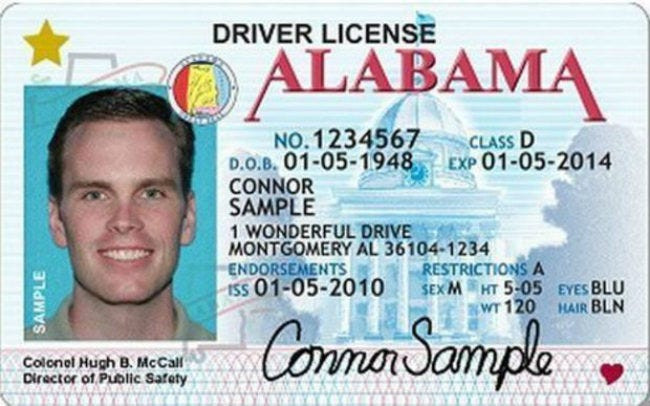
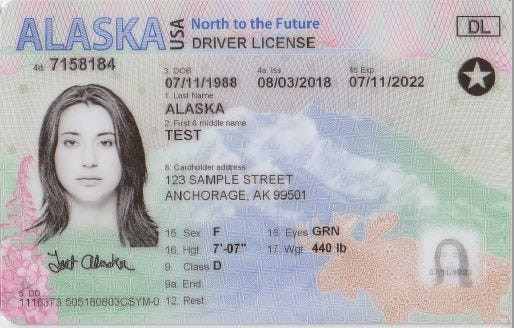
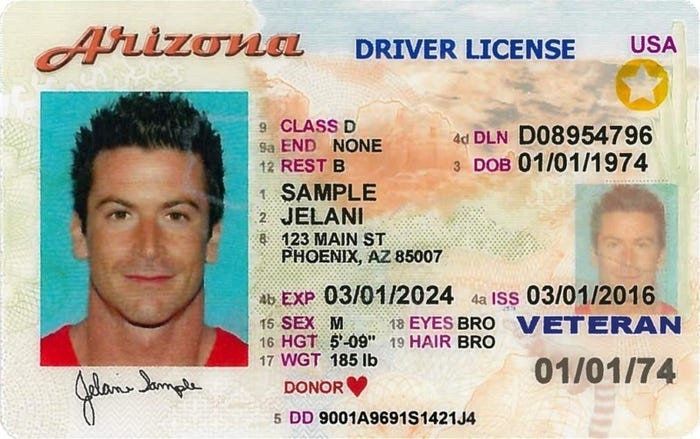
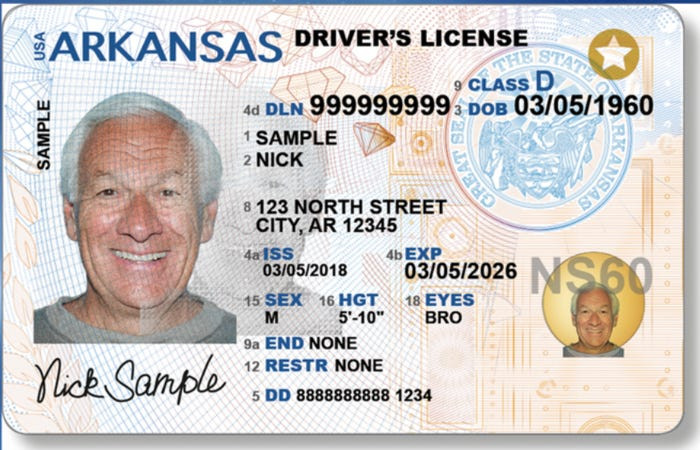

In [6]:
import json
from IPython.display import HTML, display

formatters = {
    "image": lambda x: f"<img src='{encode_image(x, format='JPEG')}' width='400'>"
}
cols = ["image_path", "image"]
display(HTML(df[cols].head(n=10).to_html(formatters=formatters, escape=False)))

Let's initialize the VLM Run Client

In [7]:
from vlmrun.client import VLMRun
from vlmrun.client.types import GenerationConfig

client = VLMRun(base_url=VLMRUN_BASE_URL, api_key=VLMRUN_API_KEY)
client

VLMRun(base_url=https://api.vlm.run/v1, api_key=z45np00n..., version=0.2.10)


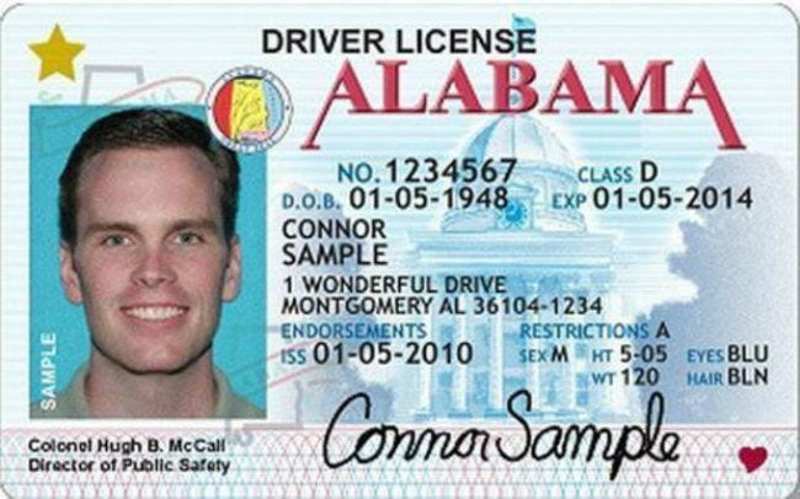

In [10]:
from vlmrun.common.viz import show_results, render_bbox_image

# Display a sample image
image = df["image"][0]

# Generate the response for the sample image
response = client.image.generate(
    images=[image],
    domain="document.us-drivers-license",
    config=GenerationConfig(
        grounding=True,
        confidence=True
    )
)

show_results(response.response, image, as_json=True)

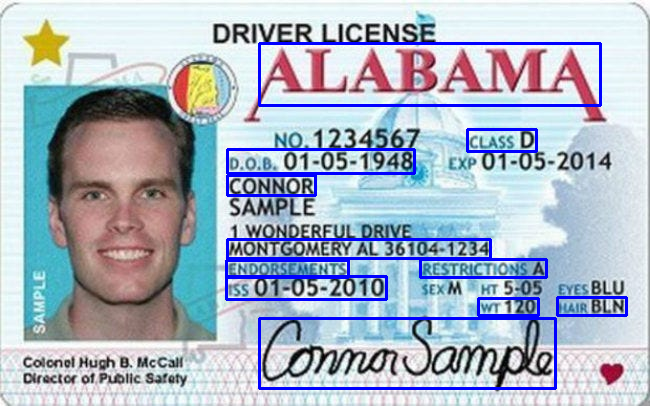

In [12]:
render_bbox_image(image, response.response)

In [13]:
def get_responses(df: pd.DataFrame) -> pd.DataFrame:
    
    def process_single_image(image):
        # Generate the response for the image using VLM Run
        vlm_response = client.image.generate(
            images=[image],
            domain="document.us-drivers-license",
            config=GenerationConfig(
                grounding=True,
                confidence=True
            )
        )
        
        return pd.Series({
            'vlm_response': vlm_response,
        })
    
    # Process all images and combine results
    responses = df['image'].apply(process_single_image)
    return pd.concat([df, responses], axis=1)

In [18]:
df_results = get_responses(df)


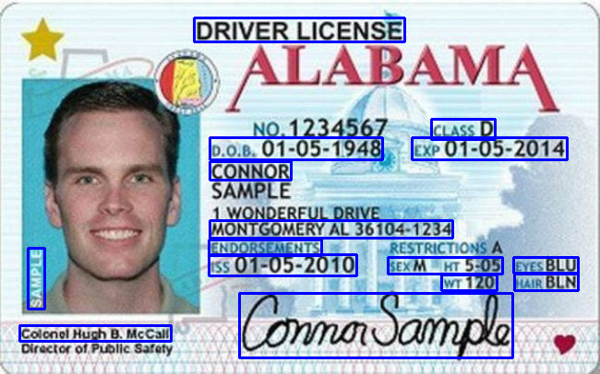
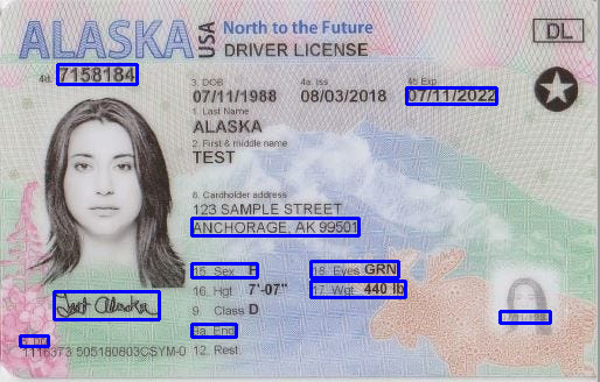
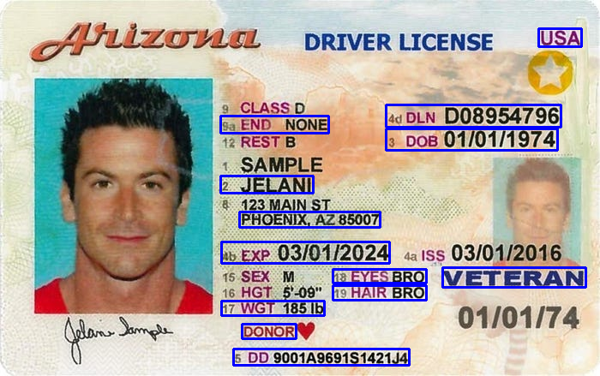
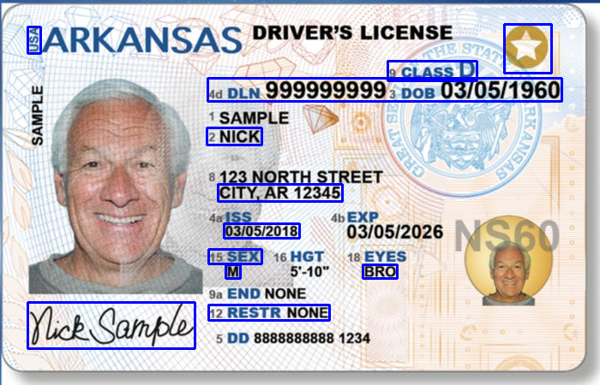

In [17]:
images = df_results['image'].tolist()
responses = [r.response for r in df_results['vlm_response'].tolist()]

# Display results
show_results(
    responses,
    images,
    render_type='bboxes',
    image_width=600,
    as_json=True
)